# Parallel ARIMA Modelling with Spark using PandasUDFs

## Model Tracking and Auditing with MLFlow

Have you ever wondered how Machine Learning Pipelines are built at scale? How can we deploy our ML models over a distributed cluster of machines so that our ML application scale horizontally? How do you track the model co-efficients as you experiment and run your models with different hyperparameters? How do track your model performance and store the best configurations in a repository? How do you retrieve the best parameters at a later stage to create predictions? Would it have been better if you had an working end-to-end application to refer? Then Read On...

This notebook covers - Parallel running of `statsmodels` ARIMA on groups of Data leveraging the new `@pandas_udf` support, use `MLflow` for Model Parameter Tracking, Logging, Retrival and Model Metrics Tracking.

The DataFrame will contain data grouped by a Machine Id. Here we woule NOT train a SINGLE model for the entire DataSet. But, we will train a separate model for each group of Data in the DataFrame. In essence, the number of models created would be equal to the number of groups in the DataFrame i.e. each Machine Id will have a separate model of its own.

I will assume some familiarity with MLflow and good familiarity with Apache Spark in this notebook.

`
@author: Anindya Saha
@email: mail.anindya@gmail.com
`

I hope you enjoy reviewing it as much as I had writing it.

## Why we use Apache Spark for ML?

![](assets/spark.jpeg)

Almost all of us who starts with Machine Learning in Python starts developing and learning using scikit-learn, pandas in Python. The datasets that we use fit in our laptops and can run with 16GB of memory. However, in reality when we go to the industry the datasets are not tiny and we need to scale with GBs of data over several machines. In order to scale our algorithm on large datasets scikit-learn, pandas are not enough. Spark is inherently designed for distributed computation and they have a [MLlib](https://spark.apache.org/docs/latest/ml-guide.html) package which has scalable implementation of most common algorithms. 

Although Spark comes with many ML model implementations out of the box but many a times we will need to build some models using Python and Pandas by ourselevs and apply that on groups of Data paralley. We can leverage Spark's new @pandas_udf support to convert Spark Grouped DataFrame records to Pandas DataFrames back and forth using Apache Arros optimization capabilities.

## Why use MLflow?

![](assets/mlflow.png)

This excerpt from Matei Zaharia himself from https://databricks.com/blog/2018/06/05/introducing-mlflow-an-open-source-machine-learning-platform.html sums up this very well. 

Everyone who has tried to do machine learning development knows that it is complex. Beyond the usual concerns in the software development, machine learning (ML) development comes with multiple new challenges. At Databricks, we work with hundreds of companies using ML, and we have repeatedly heard the same concerns:

1) There are a myriad tools.  
2) It’s hard to track experiments.  
3) It’s hard to reproduce results.  
4) It’s hard to deploy ML.  

Here is another good overview from Favio Vazquez from https://www.kdnuggets.com/2018/07/manage-machine-learning-lifecycle-mlflow.html

MLflow is an open source platform for the complete machine learning lifecycle.

MLflow is designed to work with any ML library, algorithm, deployment tool or language. It is very easy to add MLflow to your existing ML code so you can benefit from it immediately, and to share code using any ML library that others in your organization can run. MLflow is also an open source projectthat users and library developers can extend.

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import pandas_udf, PandasUDFType

import warnings
import itertools

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import mlflow

In [2]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-whitegrid')

# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 20)

In [3]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [4]:
spark = (SparkSession
         .builder
         .master('local[*]')
         .appName('applying-and-tracking-arima-model-with-pyspark-and-mlflow')
         .getOrCreate())

In [5]:
spark

## 1. Configure MLFlow:

### 1.1. Install MLFlow:

Install MLflow by running:  
`pip install mlflow`

Start MLflow:  
`mlflow server --host 0.0.0.0`  

https://www.mlflow.org/docs/latest/tracking.html

### 1.2. Create New Experiment for MLFlow:

In [6]:
mlflow.set_tracking_uri("http://172.30.2.158:5000")
mlflow.set_experiment("applying-arima-model-in-parallel-with-pyspark")

INFO: 'applying-arima-model-in-parallel-with-pyspark' does not exist. Creating a new experiment


In [7]:
client = mlflow.tracking.fluent.MlflowClient()

In [8]:
exp = client.get_experiment_by_name("applying-arima-model-in-parallel-with-pyspark")

### 1.3. Broadcast MLflow Experiment Id:

We need to broadcst the experiment id to all the executors so that the MLflow client can connect to the MLflow Tracking API using this id.

In [9]:
# we need to broadcast the experiment id to all the executors
exp_id_bc = spark.sparkContext.broadcast(exp.experiment_id)

### 1.4. Configure PandasUDF Arrow Support:

Pandas UDFs built on top of Apache Arrow bring you the best of both worlds—the ability to define low-overhead, high-performance UDFs entirely in Python.

For more details refer https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html

Refer https://spark.apache.org/docs/2.4.0/sql-pyspark-pandas-with-arrow.html for more details on how to enable Arrow.

Arrow is available as an optimization when converting a Spark DataFrame to a Pandas DataFrame using the call `toPandas()` and when creating a Spark DataFrame from a Pandas DataFrame with `createDataFrame(pandas_df)`. To use Arrow when executing these calls, users need to first set the Spark configuration `spark.sql.execution.arrow.enabled` to `true`. This is disabled by default.

In addition, optimizations enabled by `spark.sql.execution.arrow.enabled` could fallback automatically to non-Arrow optimization implementation if an error occurs before the actual computation within Spark. This can be controlled by `spark.sql.execution.arrow.fallback.enabled`.



In [10]:
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [11]:
# Enable automatic fallback to non-Arrow optimization in exception occurs
spark.conf.set("spark.sql.execution.arrow.fallback.enabled", "true")

## 2. Load Performance Metrics Data:

For this exercise we will take the famous Airline data but we will tweak it as some performance metrics for two machines. Two separate machines will represent two groups. In real Life these groups can be separate machines, airlines, customers etc. we replicate the data into two sets.

We will develop an ARIMA model to forecast performance for next 3 years.

In [12]:
# define the schema, corresponding to a line in the csv data file for log
metrics_schema = StructType([StructField('serial', IntegerType(), nullable=False), 
                         StructField('date', TimestampType(), nullable=False),
                         StructField('reads', DoubleType(), nullable=False)])

In [13]:
metrics_df = spark.read.csv('data/metrics.csv', header=True, schema=metrics_schema)

In [14]:
metrics_df.orderBy(["date", "serial"]).show(10)

+------+-------------------+-----+
|serial|               date|reads|
+------+-------------------+-----+
|     1|2003-01-01 00:00:00|141.0|
|     2|2003-01-01 00:00:00|183.3|
|     1|2003-02-01 00:00:00|157.0|
|     2|2003-02-01 00:00:00|204.1|
|     1|2003-03-01 00:00:00|185.0|
|     2|2003-03-01 00:00:00|240.5|
|     1|2003-04-01 00:00:00|199.0|
|     2|2003-04-01 00:00:00|258.7|
|     1|2003-05-01 00:00:00|203.0|
|     2|2003-05-01 00:00:00|263.9|
+------+-------------------+-----+
only showing top 10 rows



### 2.1. Visualize with Pandas DataFrame:

In [15]:
# extract out the time-series
metrics_pdf = metrics_df.toPandas()

/home/ubuntu/anaconda3/envs/spark/lib/python3.6/site-packages/pyarrow/__init__.py:159: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [16]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
metrics_pdf.set_index("date", inplace=True)

In [17]:
metrics_pdf.dtypes

serial      int32
reads     float64
dtype: object

**Plot the Time Series Data For the Two Machines:**

Here I copied the Data for one machine into other except I have scaled the values for the second machine.

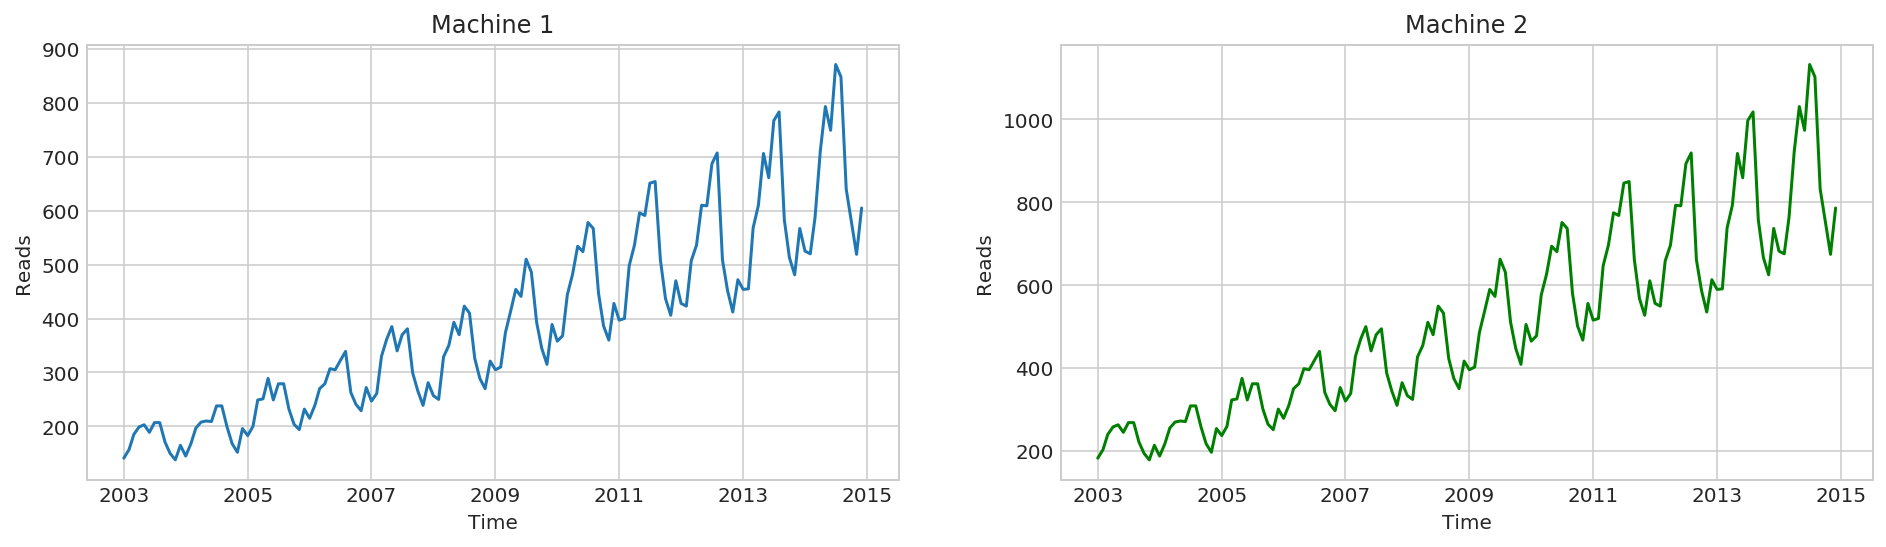

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(metrics_pdf[metrics_pdf["serial"] == 1]["reads"])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Reads')
ax[0].set_title("Machine 1")

ax[1].plot(metrics_pdf[metrics_pdf["serial"] == 2]["reads"], color='g')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Reads')
ax[1].set_title("Machine 2");

### 2.2. Total Reads Per Group (GROUPED_AGG):

I use several ideas from this blog https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html to understand how `GROUPED_AGG` and `GROUPED_MAP` should be applied.

Here we find the `total reads` per machine using the `@pandas_udf("double", PandasUDFType.GROUPED_AGG)` construct.

In [19]:
@pandas_udf("double", PandasUDFType.GROUPED_AGG)
def total_reads_udf(reads):
    return np.round(reads.sum(), 2)

In [20]:
metrics_df.groupby("serial").agg(total_reads_udf(metrics_df['reads']).alias('total_reads')).show()

+------+-----------+
|serial|total_reads|
+------+-----------+
|     1|    56116.0|
|     2|    72950.8|
+------+-----------+



### 2.3. Reads Minus Mean Reads Per Group (GROUPED_MAP):

Here we find the `deviance reads` per machine using the `@pandas_udf(mean_schema, PandasUDFType.GROUPED_MAP)` construct.

In [21]:
mean_schema = StructType([StructField('serial', IntegerType(), nullable=False),
                            StructField('date', TimestampType(), nullable=False),
                            StructField('reads', DoubleType(), nullable=False),
                            StructField('deviance', DoubleType(), nullable=False)])

In [22]:
@pandas_udf(mean_schema, PandasUDFType.GROUPED_MAP)
def subtract_mean(metrics_pdf):
    # sales_pdf is a pandas.DataFrame
    mean = metrics_pdf['reads'].mean()
    metrics_pdf['deviance'] = metrics_pdf['reads'].apply(lambda reads: np.round(reads - mean))
    return metrics_pdf

In [23]:
metrics_df.select("serial", "date", "reads").groupby("serial").apply(subtract_mean).show(10)

+------+-------------------+-----+--------+
|serial|               date|reads|deviance|
+------+-------------------+-----+--------+
|     1|2003-01-01 00:00:00|141.0|  -249.0|
|     1|2003-02-01 00:00:00|157.0|  -233.0|
|     1|2003-03-01 00:00:00|185.0|  -205.0|
|     1|2003-04-01 00:00:00|199.0|  -191.0|
|     1|2003-05-01 00:00:00|203.0|  -187.0|
|     1|2003-06-01 00:00:00|189.0|  -201.0|
|     1|2003-07-01 00:00:00|207.0|  -183.0|
|     1|2003-08-01 00:00:00|207.0|  -183.0|
|     1|2003-09-01 00:00:00|171.0|  -219.0|
|     1|2003-10-01 00:00:00|150.0|  -240.0|
+------+-------------------+-----+--------+
only showing top 10 rows



In [24]:
metrics_df.groupBy('serial').agg(F.round(F.mean(col("reads")), 2).alias("avgreads")).show()

+------+--------+
|serial|avgreads|
+------+--------+
|     1|  389.69|
|     2|   506.6|
+------+--------+



## 3. Train ARIMA Model (with @pandas_udf & GROUPED_MAP):

We will now extend the principles from `@pandas_udf` & `PandasUDFType.GROUPED_AGG` to create a method which spawns an auto ARIMA model inside it. In essence when each group of data is worked upn by a Task in an Executor, this method will only act on that data partition and create a model for that partition. The data is partitioned by Machine Id.

The train method would  
1) Log the Training Parameters and AIC score for each Run using MLflow  
2) Return a DataFrame of co-efficients for p,d,q values of the ARIMA model  

In [25]:
# practice what to return from train_arima_udf
pd.DataFrame([[1] + [1, 2, 3, 4, 5, 6]], columns=['serial', 'p', 'd', 'q', 'sp', 'sq', 'sd'])

,serial,p,d,q,sp,sq,sd
0,1,1,2,3,4,5,6


In [26]:
# we would return a DataFrame of co-efficients hence we need a schema for that
arima_model_schema = StructType([StructField('serial', IntegerType(), nullable=False), 
                         StructField('p', IntegerType(), nullable=False),
                         StructField('d', IntegerType(), nullable=False),
                         StructField('q', IntegerType(), nullable=False),
                         StructField('sp', IntegerType(), nullable=False),
                         StructField('sd', IntegerType(), nullable=False),
                         StructField('sq', IntegerType(), nullable=False),
                         StructField('aic', DoubleType(), nullable=False),
                         StructField('mse', DoubleType(), nullable=False)])

### 3.1. Create a `@pandas_udf` that should be applied to each partition:

The training method logs the parameters p, d, q for each run and tags that as `stage=train`. In the final step, it also logs the best p, d, q for all the runs and tags that as `stage=best`. I use tags here so that in the later stage when I need to lookup a parameter I can look up by this tag the best run. We will see that usage in Section 4.

In [27]:
@pandas_udf(arima_model_schema, PandasUDFType.GROUPED_MAP)
def train_arima_udf_mlflow(metrics_pdf):
    
    import sys
    import warnings
    import itertools

    import statsmodels.api as sm
    import statsmodels.tsa.api as smt
    import statsmodels.formula.api as smf
    
    import mlflow
    mlflow.set_tracking_uri("http://172.30.2.158:5000")
    
    # retrieve the broadcasted experiment id so that we can query MLflow with that id
    exp_id = exp_id_bc.value
    
    # extract out the Machine Id
    group_key = metrics_pdf["serial"].iloc[0]
    metrics_pdf.sort_values(by='date')
    
    # metrics_pdf is a pandas.DataFrame
    
    # set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
    metrics_pdf.set_index("date", inplace=True)
    
    metrics_ts_log = np.log10(metrics_pdf["reads"])
    metrics_ts_log.dropna(inplace=True)
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    temp_model = None    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:

            # create a new run with MLflow and log the parameters and metrics
            with mlflow.start_run(experiment_id=exp_id, entry_point_name="spark_arima"):
                
                mlflow.set_tag("stage", "train")
                
                mlflow.log_param("serial", group_key)
                
                mlflow.log_param("p", param[0])
                mlflow.log_param("d", param[1])
                mlflow.log_param("q", param[2])

                mlflow.log_param("sp", param_seasonal[0])
                mlflow.log_param("sd", param_seasonal[1])
                mlflow.log_param("sq", param_seasonal[2])

                try:
                    temp_model = sm.tsa.statespace.SARIMAX(metrics_ts_log,
                                                     order = param,
                                                     seasonal_order = param_seasonal,
                                                     enforce_stationarity=True,
                                                     enforce_invertibility=True)
                    results = temp_model.fit()



                    mlflow.log_metric("aic", results.aic)

                    # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_pdq = param
                        best_seasonal_pdq = param_seasonal
                except:
                    #print("Unexpected error:", sys.exc_info()[0])
                    continue
    
    best_p, best_d, best_q, best_sp, best_sd, best_sq = best_pdq[0], best_pdq[1], best_pdq[2], best_seasonal_pdq[0], best_seasonal_pdq[1], best_seasonal_pdq[2]    
                
    # Fit best ARIMA Model based on best params found from training
    best_model = sm.tsa.statespace.SARIMAX(metrics_ts_log,
                                      order=(best_p, best_d, best_q),
                                      seasonal_order=(best_sp, best_sd, best_sq, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
    best_results = best_model.fit()
    
    pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)

    # Extract the predicted and true values of our time series
    metrics_ts_predicted = pred_dynamic.predicted_mean
    metrics_ts_truth = metrics_ts_log['2012-01-01':]
    
    # Compute the mean square error
    best_mse = ((metrics_ts_predicted - metrics_ts_truth) ** 2).mean()
    
    with mlflow.start_run(experiment_id=exp_id, entry_point_name="spark_arima"):

            mlflow.set_tag("stage", "best")

            mlflow.log_param("serial", group_key)

            mlflow.log_param("p", best_p)
            mlflow.log_param("d", best_d)
            mlflow.log_param("q", best_q)

            mlflow.log_param("sp", best_sp)
            mlflow.log_param("sd", best_sd)
            mlflow.log_param("sq", best_sq)
            
            mlflow.log_metric("best_aic", best_aic)
            mlflow.log_metric("best_mse", best_mse)
            
    return pd.DataFrame([[group_key] + [best_p, best_d, best_q, best_sp, best_sd, best_sq, best_aic, best_mse]],
                       columns=["serial", "p", "d", "q", "sp", "sq", "sd", "aic", "mse"])

### 3.2. Test the pandas_udf on a sample group:

We can test the pandas_udf on a sample group just like any normal python method before applying it to the Spark DataFrame.

In [28]:
# Filter out a group of sample data
group_1_sample = metrics_df.filter(col("serial") == 1).select("serial", "date", "reads").toPandas()

/home/ubuntu/anaconda3/envs/spark/lib/python3.6/site-packages/pyarrow/__init__.py:159: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [29]:
group_1_sample.head()

,serial,date,reads
0,1,2003-01-01,141.0
1,1,2003-02-01,157.0
2,1,2003-03-01,185.0
3,1,2003-04-01,199.0
4,1,2003-05-01,203.0


In [30]:
# Run as a standalone function on a pandas.DataFrame and verify result
train_arima_udf_mlflow.func(group_1_sample)

,serial,p,d,q,sp,sq,sd,aic,mse
0,1,0,1,1,1,0,1,-733.774589,0.001078


### 3.3. Apply pandas_udf on the entire Spark DataFrame:

In [31]:
# Now run with Spark
models = metrics_df.select("serial", "date", "reads").groupby("serial").apply(train_arima_udf_mlflow)

In [32]:
models.show()

+------+---+---+---+---+---+---+------------------+--------------------+
|serial|  p|  d|  q| sp| sd| sq|               aic|                 mse|
+------+---+---+---+---+---+---+------------------+--------------------+
|     1|  0|  1|  1|  1|  1|  0|-733.7745891687371|0.001078132597325...|
|     2|  0|  1|  1|  1|  1|  0|-733.7745996470192|0.001077656581180...|
+------+---+---+---+---+---+---+------------------+--------------------+



## 4. Predict with the best ARIMA Model for each Machine:

We will now extend the principles from `@pandas_udf` & `PandasUDFType.GROUPED_AGG` to create a method which works on each partition of data and does the following:

1) Look Up the best values of p,d,q parameter of ARIMA model for that partition  
2) Query the MLflow Tracking API to fetch the best parameters  
3) Use the best parameters to predict on the Test Set  

### 4.1. Get Latest Run Info for Serial No:

Here we build a client to the MLflow Tracking API and use different APIs to find out the Run which is tagged as `best` and extract out the p, d, q parameters from that.

In [33]:
def get_latest_run_param(serial, entry_point_name="spark_arima"):
    
    import mlflow
    mlflow.set_tracking_uri("http://172.30.2.158:5000")

    client = mlflow.tracking.fluent.MlflowClient()
    
    exp = client.get_experiment_by_name("applying-arima-model-in-parallel-with-pyspark")
    
    all_run_infos = reversed(client.list_run_infos(experiment_id=exp.experiment_id))
    
    for run_info in all_run_infos:
        
        if run_info.entry_point_name != "spark_arima":
            continue

        full_run = client.get_run(run_info.run_uuid)

        #print(full_run)
        #print(full_run.data.params)

        run_params = {param.key: param.value for param in full_run.data.params}

        if run_params['serial'] == serial:
            run_tags = {tag.key: tag.value for tag in full_run.data.tags}
            if run_tags["stage"] == "best":
                return (int(run_params["p"]), int(run_params["d"]), int(run_params["q"]), int(run_params["sp"]), int(run_params["sd"]), int(run_params["sq"]))

In [34]:
get_latest_run_param(serial="1")

(0, 1, 1, 1, 0, 1)

In [35]:
get_latest_run_param(serial="2")

(0, 1, 1, 1, 0, 1)

### 4.2. Predict with best ARIMA Model (with @pandas_udf & GROUPED_MAP):

In [36]:
# we would return a DataFrame of predictions hence we need a schema for that
arima_predict_schema = StructType([StructField('serial', IntegerType(), nullable=False),
                         StructField('date', TimestampType(), nullable=False),
                         StructField('predicted', DoubleType(), nullable=False),
                         StructField('lower_ci_95', DoubleType(), nullable=False),
                         StructField('upper_ci_95', DoubleType(), nullable=False)])

Create a `@pandas_udf` that should be applied to each partition:

The predict method fetches the best parameters p, d, q for each partition that is tagged as `stage=best`. I will use these best parameters to generate the predictions.

In [37]:
@pandas_udf(arima_predict_schema, PandasUDFType.GROUPED_MAP)
def predict_arima_udf_mlflow(metrics_pdf):
    
    # metrics_pdf is a pandas.DataFrame
    
    import warnings
    import itertools

    import statsmodels.api as sm
    import statsmodels.tsa.api as smt
    import statsmodels.formula.api as smf
    
    # extract out the Machine Id
    group_key = metrics_pdf["serial"].iloc[0]
    
    # sort the dataframe by date
    metrics_pdf.sort_values(by='date')
    
    # set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
    metrics_pdf.set_index("date", inplace=True)
    
    metrics_ts_log = np.log10(metrics_pdf["reads"])
    metrics_ts_log.dropna(inplace=True)
    
    # Fetch the best p, d and q parameters fr=or the ARIMA model for this Machine using MLflow
    best_p, best_d, best_q, best_sp, best_sd, best_sq = get_latest_run_param(serial=str(group_key))
    
    # Create an ARIMA Model based on the best params for this machine id found from training
    best_model = sm.tsa.statespace.SARIMAX(metrics_ts_log,
                                      order=(best_p, best_d, best_q),
                                      seasonal_order=(best_sp, best_sd, best_sq, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
    best_results = best_model.fit()
    
    pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()

    # Extract the predicted and true values of our time series
    metrics_ts_predicted = pred_dynamic.predicted_mean
    metrics_ts_truth = metrics_ts_log['2012-01-01':]
    
    idx = metrics_ts_truth.index
    n_steps = len(idx)
    
    # create the prediction DataFrame
    pred_95 = pd.DataFrame(np.column_stack([np.power(10, pred_dynamic.predicted_mean), np.power(10, pred_dynamic_ci)]), index=idx)
    pred_95.reset_index(inplace=True)
    pred_95["serial"] = pd.Series([group_key] * n_steps)
    
    pred_95.columns=["date", "predicted", "lower_ci_95", "upper_ci_95", "serial"]
    pred_95 = pred_95[["serial", "date", "predicted", "lower_ci_95", "upper_ci_95"]]
    
    return pred_95

### 4.3. Test the pandas_udf on a sample group:

We can test the pandas_udf on a sample group just like any normal python method before applying it to the Spark DataFrame.

In [38]:
# Filter out a group of sample data
group_1_sample = metrics_df.filter(col("serial") == 1).select("serial", "date", "reads").toPandas()

In [39]:
group_1_sample.head()

,serial,date,reads
0,1,2003-01-01,141.0
1,1,2003-02-01,157.0
2,1,2003-03-01,185.0
3,1,2003-04-01,199.0
4,1,2003-05-01,203.0


In [40]:
get_latest_run_param(serial=str(1))

(0, 1, 1, 1, 0, 1)

In [41]:
# Run as a standalone function on a pandas.DataFrame and verify result
predict_arima_udf_mlflow.func(group_1_sample).head(5)

,serial,date,predicted,lower_ci_95,upper_ci_95
0,1,2012-01-01,441.682877,411.141371,474.493149
1,1,2012-02-01,449.667904,412.957580,489.641633
2,1,2012-03-01,552.341019,501.377356,608.485002
3,1,2012-04-01,596.098896,535.507493,663.546072
4,1,2012-05-01,658.492144,585.986460,739.969153


### 4.4. Apply pandas_udf on the entire Spark DataFrame:

In [42]:
# Now run with Spark
preds = metrics_df.select("serial", "date", "reads").groupby("serial").apply(predict_arima_udf_mlflow)

In [43]:
preds.show(5)

+------+-------------------+-----------------+------------------+------------------+
|serial|               date|        predicted|       lower_ci_95|       upper_ci_95|
+------+-------------------+-----------------+------------------+------------------+
|     1|2012-01-01 00:00:00|441.6828770973009|411.14137142539823|474.49314877898985|
|     1|2012-02-01 00:00:00|449.6679039054397| 412.9575799578932|489.64163298159826|
|     1|2012-03-01 00:00:00|552.3410190907395|501.37735577093594| 608.4850020821017|
|     1|2012-04-01 00:00:00| 596.098895744265|  535.507492831023| 663.5460722109001|
|     1|2012-05-01 00:00:00|658.4921444802321|  585.986460212436| 739.9691525039311|
+------+-------------------+-----------------+------------------+------------------+
only showing top 5 rows



### 4.5. Visualize the Predictions:

In [44]:
preds_pdf = preds.toPandas()

In [45]:
preds_pdf.dtypes

serial                  int32
date           datetime64[ns]
predicted             float64
lower_ci_95           float64
upper_ci_95           float64
dtype: object

In [46]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
preds_pdf.set_index("date", inplace=True)

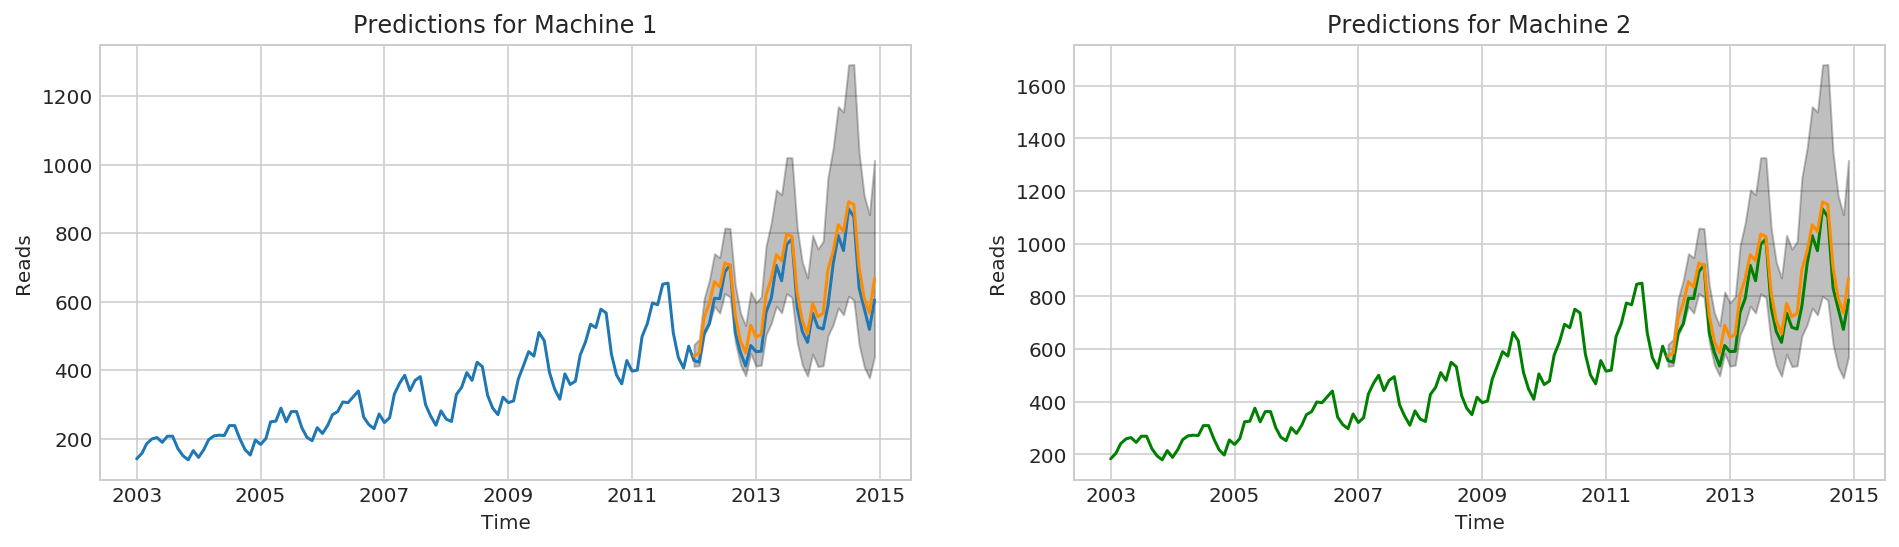

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(metrics_pdf[metrics_pdf["serial"] == 1]["reads"])
ax[0].plot(preds_pdf[preds_pdf["serial"] == 1]["predicted"], color='darkorange')
ax[0].fill_between(preds_pdf[preds_pdf["serial"] == 1].index, preds_pdf[preds_pdf["serial"] == 1]["lower_ci_95"], preds_pdf[preds_pdf["serial"] == 1]["upper_ci_95"], color='k', alpha=.25)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Reads')
ax[0].set_title("Predictions for Machine 1")

ax[1].plot(metrics_pdf[metrics_pdf["serial"] == 2]["reads"], color='g')
ax[1].plot(preds_pdf[preds_pdf["serial"] == 2]["predicted"], color='darkorange')
ax[1].fill_between(preds_pdf[preds_pdf["serial"] == 2].index, preds_pdf[preds_pdf["serial"] == 2]["lower_ci_95"], preds_pdf[preds_pdf["serial"] == 2]["upper_ci_95"], color='k', alpha=.25)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Reads')
ax[1].set_title("Predictions for Machine 2");

We can clearly see that the ARIMA models have learned their parameters well for each of the Machines and the predictions are plotted along with the confidence bands.

## 5. Forecast with the best ARIMA Model for each Machine:

We will now extend the principles from `@pandas_udf` & `PandasUDFType.GROUPED_AGG` to create a method which works on each partition of data and does the following:

1) Look Up the best values of p,d,q parameter of ARIMA model for that partition/machine id
2) Query the MLflow Tracking API to fetch the best parameters  
3) Use the best parameters to forecast on a future time frame  

### 5.1. Create a `@pandas_udf` that should be applied to each partition:

The forecast method fetches the best parameters p, d, q for each partition that is tagged as `stage=best`. I will use these best parameters to generate the forecasts for future time frames.

In [48]:
@pandas_udf(arima_predict_schema, PandasUDFType.GROUPED_MAP)
def forecast_arima_udf_mlflow(metrics_pdf):
    
    # metrics_pdf is a pandas.DataFrame
    
    import warnings
    import itertools

    import statsmodels.api as sm
    import statsmodels.tsa.api as smt
    import statsmodels.formula.api as smf
    
    # extract out the Machine Id
    group_key = metrics_pdf["serial"].iloc[0]
    
    # sort the dataframe by date
    metrics_pdf.sort_values(by='date')
    
    # set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
    metrics_pdf.set_index("date", inplace=True)
    
    metrics_ts_log = np.log10(metrics_pdf["reads"])
    metrics_ts_log.dropna(inplace=True)
    
    # Fetch the best p, d and q parameters fr=or the ARIMA model for this Machine using MLflow
    best_p, best_d, best_q, best_sp, best_sd, best_sq = get_latest_run_param(serial=str(group_key))
    
    # Create an ARIMA Model based on the best params for this machine id found from training
    best_model = sm.tsa.statespace.SARIMAX(metrics_ts_log,
                                      order=(best_p, best_d, best_q),
                                      seasonal_order=(best_sp, best_sd, best_sq, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
    best_results = best_model.fit()
    
    # Get forecast 36 steps (3 years) ahead in future
    n_steps = 36
    forecast_uc_95 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 95% CI
    
    # Get confidence intervals 95% of the forecasts
    forecast_ci_95 = forecast_uc_95.conf_int()
    
    idx = pd.date_range(metrics_ts_log.index[-1], periods=n_steps, freq='MS')
    
    # create the forecast DataFrame
    forecast_95 = pd.DataFrame(np.column_stack([np.power(10, forecast_uc_95.predicted_mean), np.power(10, forecast_ci_95)]), index=idx)
    
    forecast_95.reset_index(inplace=True)
    forecast_95["serial"] = pd.Series([group_key] * n_steps)
    
    forecast_95.columns=["date", "predicted", "lower_ci_95", "upper_ci_95", "serial"]
    forecast_95 = forecast_95[["serial", "date", "predicted", "lower_ci_95", "upper_ci_95"]]
    
    return forecast_95

### 5.2. Apply pandas_udf on the entire Spark DataFrame:

In [49]:
# Now run with Spark
forecasts = metrics_df.select("serial", "date", "reads").groupby("serial").apply(forecast_arima_udf_mlflow)

In [50]:
forecasts.show(5)

+------+-------------------+-----------------+-----------------+-----------------+
|serial|               date|        predicted|      lower_ci_95|      upper_ci_95|
+------+-------------------+-----------------+-----------------+-----------------+
|     1|2014-12-01 00:00:00|567.4654610473998|528.2271947182152|  609.61846096076|
|     1|2015-01-01 00:00:00|566.2088189379161|519.9850443364655|616.5416296773815|
|     1|2015-02-01 00:00:00|668.8450309904786|607.1326405108307|736.8302173710489|
|     1|2015-03-01 00:00:00|  755.21699571891|678.4528096897852|840.6667383152017|
|     1|2015-04-01 00:00:00|850.2372872479283|756.6199513227858|955.4379888646555|
+------+-------------------+-----------------+-----------------+-----------------+
only showing top 5 rows



### 5.3. Visualize the Predictions:

In [51]:
forecasts_pdf = forecasts.toPandas()

In [52]:
forecasts_pdf.dtypes

serial                  int32
date           datetime64[ns]
predicted             float64
lower_ci_95           float64
upper_ci_95           float64
dtype: object

In [53]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
forecasts_pdf.set_index("date", inplace=True)

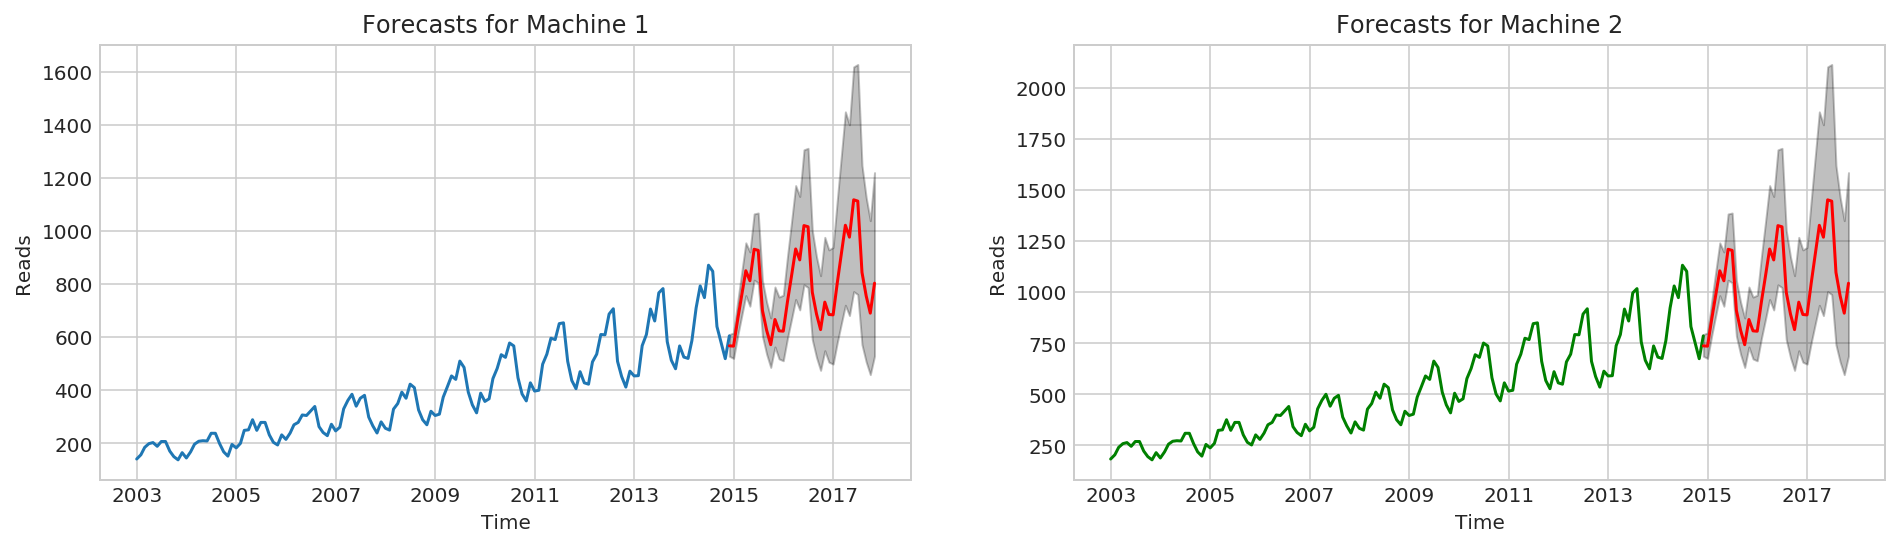

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(metrics_pdf[metrics_pdf["serial"] == 1]["reads"])
ax[0].plot(forecasts_pdf[forecasts_pdf["serial"] == 1]["predicted"], color='red')
ax[0].fill_between(forecasts_pdf[forecasts_pdf["serial"] == 1].index, forecasts_pdf[forecasts_pdf["serial"] == 1]["lower_ci_95"], forecasts_pdf[forecasts_pdf["serial"] == 1]["upper_ci_95"], color='k', alpha=.25)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Reads')
ax[0].set_title("Forecasts for Machine 1")

ax[1].plot(metrics_pdf[metrics_pdf["serial"] == 2]["reads"], color='g')
ax[1].plot(forecasts_pdf[forecasts_pdf["serial"] == 2]["predicted"], color='red')
ax[1].fill_between(forecasts_pdf[forecasts_pdf["serial"] == 2].index, forecasts_pdf[forecasts_pdf["serial"] == 2]["lower_ci_95"], forecasts_pdf[forecasts_pdf["serial"] == 2]["upper_ci_95"], color='k', alpha=.25)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Reads')
ax[1].set_title("Forecasts for Machine 2");

We can clearly see that the ARIMA models have learned their parameters well for each of the Machines and the forecasts are plotted along with the confidence bands.

In [55]:
spark.stop()